TRAIN_DIR: C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\pc\Desktop\i2\deeplearning\projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


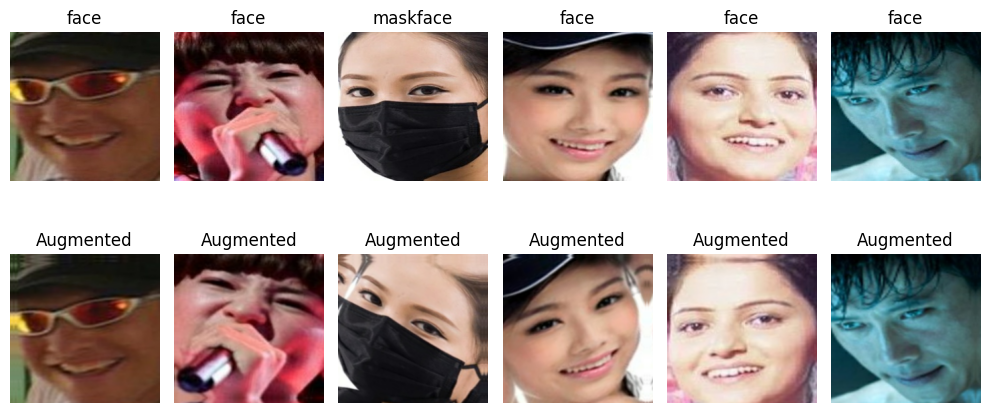

In [18]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

# Modèle 3 : VGG16 amélioré (fine-tuning)

Ce modèle améliore VGG16 de base en :

- gardant VGG16 pré-entraîné sur ImageNet,
- activant le fine-tuning sur les **derniers blocs convolutionnels**,
- ajoutant une tête de classification plus riche :
  - GlobalAveragePooling2D
  - Dense(512) + BatchNorm + Dropout (0.5)
  - Dense(128) + Dropout (0.3)
- régularisation L2 pour limiter l’overfitting.

Objectif : obtenir de meilleures performances que VGG16 simple (Modèle 2).


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

# Base VGG16
base_model4 = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# On débloque seulement les derniers blocs pour le fine-tuning
trainable = False
for layer in base_model4.layers:
    if "block5" in layer.name or "block4" in layer.name:
        trainable = True
    layer.trainable = trainable

print("Nombre de couches trainables :", len([l for l in base_model4.layers if l.trainable]))

# Tête de classification améliorée
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model4(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    512,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_vgg4 = keras.Model(inputs, outputs, name="vgg16_finetuned")

model_vgg4.summary()


Nombre de couches trainables : 8
Model: "vgg16_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)    

## Compilation + callbacks (Modèle 4)

On utilise :
- Adam avec un **learning rate plus petit** (1e-4) pour le fine-tuning,
- binary_crossentropy,
- accuracy, precision, recall,
- sauvegarde du meilleur modèle,
- EarlyStopping + ReduceLROnPlateau.


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_vgg4.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

checkpoint_vgg4 = ModelCheckpoint(
    "models/vgg16_finetuned_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop_vgg4 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_vgg4 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)


## Entraînement du Modèle 4 (VGG16 amélioré)


In [9]:
history_vgg4 = model_vgg4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_vgg4, early_stop_vgg4, reduce_lr_vgg4],
    verbose=1
)

Epoch 1/10
149/149 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8762 - precision: 0.8797 - recall: 0.8689
Epoch 1: val_loss improved from inf to 0.54307, saving model to models\vgg16_finetuned_best.h5
149/149 [==============================] - 134s 681ms/step - loss: 0.3716 - accuracy: 0.8762 - precision: 0.8797 - recall: 0.8689 - val_loss: 0.5431 - val_accuracy: 0.8695 - val_precision: 0.9915 - val_recall: 0.7545 - lr: 1.0000e-04
Epoch 2/10
149/149 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9380 - precision: 0.9444 - recall: 0.9296
Epoch 2: val_loss did not improve from 0.54307
149/149 [==============================] - 83s 555ms/step - loss: 0.2366 - accuracy: 0.9380 - precision: 0.9444 - recall: 0.9296 - val_loss: 1.0919 - val_accuracy: 0.7963 - val_precision: 0.9921 - val_recall: 0.6114 - lr: 1.0000e-04
Epoch 3/10
149/149 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9418 - precision: 0.9467 - recall:

## Courbes Loss & Accuracy (Modèle 4)


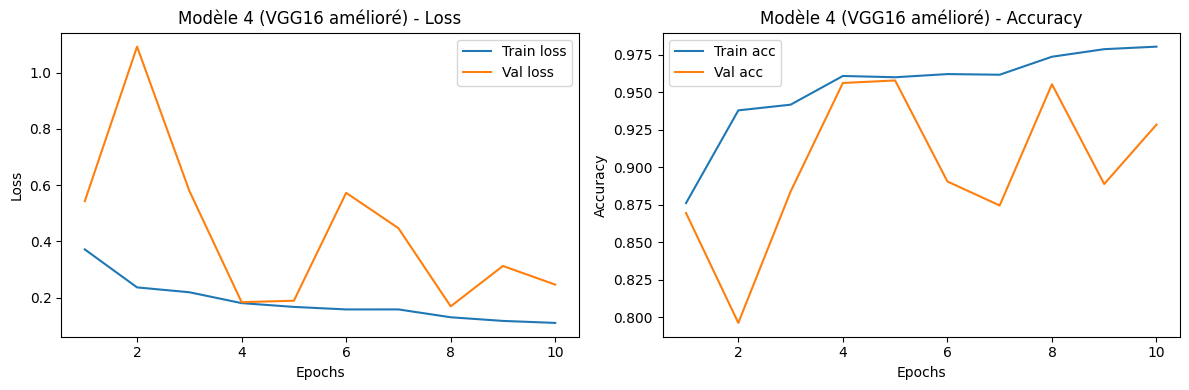

In [16]:
from load import plot_history
plot_history(history_vgg4, title_prefix="Modèle 4 (VGG16 amélioré)")

## Évaluation sur le test (Modèle 3)


In [19]:
test_results_vgg4 = model_vgg4.evaluate(test_ds, verbose=1)

print("\nRésultats Modèle 3 (VGG16 amélioré) :")
for name, value in zip(model_vgg4.metrics_names, test_results_vgg4):
    print(f"{name}: {value:.4f}")


96/96 [==============================] - 13s 136ms/step - loss: 0.3817 - accuracy: 0.8627 - precision: 0.7155 - recall: 0.9904

Résultats Modèle 3 (VGG16 amélioré) :
loss: 0.3817
accuracy: 0.8627
precision: 0.7155
recall: 0.9904


##  Matrice de confusion et rapport de classification (Modèle 3)

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = model_vgg4.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


96/96 [==============================] - 14s 141ms/step
Confusion Matrix:
 [[1609  410]
 [  10 1031]]

Classification Report:
              precision    recall  f1-score   support

        face       0.99      0.80      0.88      2019
    maskface       0.72      0.99      0.83      1041

    accuracy                           0.86      3060
   macro avg       0.85      0.89      0.86      3060
weighted avg       0.90      0.86      0.87      3060



## Résumé du Modèle 4 – VGG16 amélioré (fine-tuning)

### 🔹 Performances sur le test
- **Accuracy : 86.27%**
- **Precision : 71.55%**
- **Recall : 99.04%**
- **Loss : 0.3817**

### 🔹 Matrice de confusion
| Classe     | Bien classé | Mal classé |
|------------|-------------|------------|
| face       | 1609        | 410        |
| maskface   | 1031        | 10         |

### 🔹 Analyse
- Le modèle détecte **presque parfaitement les images “maskface”**  
  → recall **0.99**, exceptionnel.
- Mais il confond énormément les images “face” → **410 erreurs**.
- Le modèle est **trop sensible au masque** (biais du fine-tuning).
- L’ajout des couches + déblocage de `block4`/`block5` a rendu le modèle **instable** :
  - training accuracy très haute,
  - validation fluctuante,
  - et test accuracy plus faible.

### 🔹 Courbes  
- **Train loss** : diminue fortement → bon apprentissage interne.  
- **Val loss** : très irrégulière → modèle sur-fit sur les derniers blocs fine-tunés.  
- **Train accuracy** : ~98%  
- **Val accuracy** : instable entre 80% et 96%.  

### 🔹 Conclusion
Même si le modèle détecte presque toutes les images avec masque,  
il est **trop déséquilibré** :  
il **surestime la classe “maskface”** après le fine-tuning.

➡️ **Moins bon que les modèles précédents**  
➡️ Montre que le fine-tuning sur VGG16 est difficile sur un dataset binaire simple.  
➡️ On corrigera ça avec MobileNetV2 et EfficientNet, qui sont plus modernes et plus stables.
